# Refactored Simstock demo session

---

## Plan

1) Quick into to code
2) Installation guide
3) Demo 1: simple test data
4) Demo 2: larger geopackage data
5) Demo 3: geopackage data with missing fields
6) Discussion

---

## Quick overview and basic usage 

Simstock broadly does two things: preprocesses data, and then saves it to an idf file. The refactoring has seperated these two actions into two base objects: the ``SimstockDataframe`` and the ``IDFmanager``. Basic workflow:

In [22]:
import simstock as sim

# Read in data
sdf = sim.read_csv("tests/data/test_data.csv")
# print(sdf)

# Adjust settings if needed:
# sdf.settings.printidf()
print(sdf.materials[0])

# # Process it
# sdf.preprocessing()

# # Create simulation IDF
# simulation = sim.IDFmanager(sdf)
# simulation.create_model_idf()

# # Have a look at it
# simulation.idf.printidf()


Material,
    10mm_carpet,              !- Name
    Rough,                    !- Roughness
    0.01,                     !- Thickness
    0.058,                    !- Conductivity
    20,                       !- Density
    1000,                     !- Specific Heat
    0.9,                      !- Thermal Absorptance
    0.5,                      !- Solar Absorptance
    0.5;                      !- Visible Absorptance



## Installation

This will change! 

For now, install poetry. 

Then:

- Clone from github
- Run poetry install

---

## First demo

- Create a file script.py in your directory.
- Read in data:

In [ ]:
import simstock as sim

sdf = sim.read_csv("tests/data/test_data.csv")

Play around with it:

- Plot
- Access fields


In [23]:
print(sdf['osgb'])

0        osgb1000005307038
1        osgb1000005307037
2        osgb1000005307041
3        osgb1000005307012
4        osgb1000005306985
5        osgb1000005306983
6        osgb1000005306850
7        osgb1000005307039
8        osgb1000005307033
9        osgb1000005307034
10       osgb1000005307040
11       osgb1000005307042
12       osgb1000005307043
13       osgb1000005307011
14       osgb1000005306986
15       osgb1000005306982
16       osgb1000005306984
17    osgb5000005160060964
Name: osgb, dtype: object


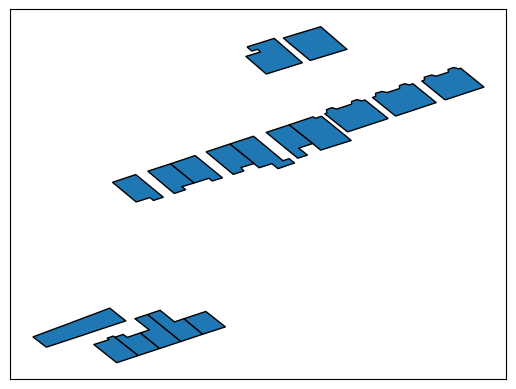

In [12]:
import matplotlib.pyplot as plt

sim.plot(sdf)
plt.show()

In [ ]:
print(sdf.materials)

In [ ]:
sdf.settings.printidf()

The ``SimstockDataframe`` can be accessed in the same manner as a Pandas dataframe. E.g.

In [ ]:
print(sdf.loc[sdf["osgb"] == "osgb1000005307038", "polygon"])

In [ ]:
print(sdf.columns)

- Now do some processing (see what error occurs):

In [24]:
# Create simulation IDF
simulation = sim.IDFmanager(sdf)
simulation.create_model_idf()

# Have a look at it
simulation.idf.printidf()

SimstockException: Error: the following columns are missing from the data: 
['touching', 'interiors', 'polygon_exposed_wall', 'polygon_horizontal'] 
Please pre-process the data accordingly using Simstock.

In [25]:
# Remember to pre-process
sdf.preprocessing()

# Create simulation IDF
simulation = sim.IDFmanager(sdf)
simulation.create_model_idf()

# Have a look at it
simulation.idf.printidf()

The BI(s) with the most buildings: ['bi_528830-15_186037-12'] with 2 thermally simulated buildings

SimulationControl,
    No,                       !- Do Zone Sizing Calculation
    No,                       !- Do System Sizing Calculation
    No,                       !- Do Plant Sizing Calculation
    No,                       !- Run Simulation for Sizing Periods
    Yes;                      !- Run Simulation for Weather File Run Periods

Building,
    building,                 !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.4,                      !- Temperature Convergence Tolerance Value
    FullExterior,             !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

ShadowCalculation,
    AverageOverDaysInFrequency,    !- Calculation Method
    20,                  

## Finer grained control 

In [ ]:
# Set kwargs
kwargs = {"tol" : 0.1}

# Read in data
sdf = sim.read_csv("tests/data/test_data.csv")
 
# Ensure exteriors and interiors are oriented correctly
sdf.orientate_polygons(**kwargs)

# Remove duplicate coordinates from polygons
sdf.remove_duplicate_coords(**kwargs)

# Check for polygons intersecting each other
sdf.polygon_topology(**kwargs)

# Assess which polygons need simplifying
sdf.polygon_tolerance(**kwargs)

# Simplify relevant polygons
sdf.polygon_simplification(**kwargs)

# Check again that polygons are not intersecting each other
sdf.polygon_topology(**kwargs)

# Remove collinear points, determine exterior surfaces coordinates
sdf.collinear_exterior(**kwargs)

# Final check that nothing is interecting after the above processing
# It pays to repeatedly check this
sdf.polygon_topology(**kwargs)

# Check for built islands
sdf.bi_adj()

# We now have proprocessed data ready to be turned into an IDF file
# To turn it into an IDF file, we can either call create_idf,
# or instantiate an IDFcreator object for finer grained control:
idfkwargs = {"min_avail_height" : 80}
ob = sim.IDFmanager(sdf)
 
# Move all objects towards origin
ob.move_towards_origin(**idfkwargs)

# Create shading objects
ob.create_shading_objects(**idfkwargs)
 
# Create thermal zones based on floor number
ob.create_thermal_zones(**idfkwargs)

# Compute ideal load systems
ob.create_load_systems(**idfkwargs)

# All relevant data for an E+ run have now been created
# The results can be saved to a file,
# Or kept as an eppy idf object for further processing:
ob.idf.printidf()

## Demo 2 

Using geopackage data, and build custom settings.

['test_blank', 'test_with_data', 'test_full', 'classwork_with_data']


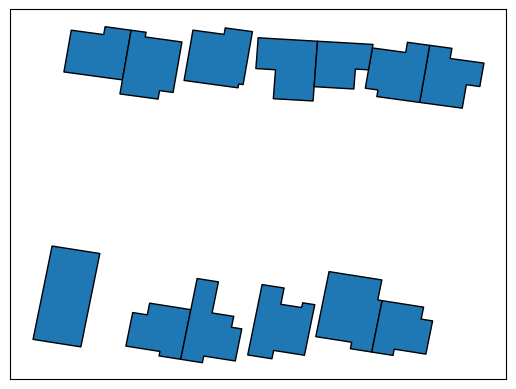

In [26]:
import os

# Path to test data
s7data = os.path.join("tests", "data", "S7_data.gpkg")

# Layer names
layers = sim.get_gpkg_layer_names(s7data)
print(layers)

# Initialise
sdf = sim.read_geopackage_layer(s7data, "test_full", uid_column_name="UID", index="fid", use_base=True)

sim.plot(sdf)
plt.show()


Create custom csvs for inputting more settings:

In [29]:
# Add option too specify absolute path
sdf.create_csv_folder(dirname="simulation_settings")

sdf.override_settings_with_csv()

sdf.preprocessing()

# print(sdf.columns)

# Create simulation IDF
simulation = sim.IDFmanager(sdf)
simulation.create_model_idf_with_bi()

# Have a look at it
simulation.idf.printidf()



SimulationControl,
    No,                       !- Do Zone Sizing Calculation
    No,                       !- Do System Sizing Calculation
    No,                       !- Do Plant Sizing Calculation
    No,                       !- Run Simulation for Sizing Periods
    Yes;                      !- Run Simulation for Weather File Run Periods

Building,
    bi_534364-1_165700-92,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.4,                      !- Temperature Convergence Tolerance Value
    FullExterior,             !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

ShadowCalculation,
    AverageOverDaysInFrequency,    !- Calculation Method
    20,                       !- Calculation Frequency
    15000,                    !- Maximum Figures in Shadow Overlap Ca

## Demo 3

Incomplete data

In [30]:
# Initialise
sdf = sim.read_geopackage_layer(s7data, "test_with_data", uid_column_name="id", index="fid", use_base=True)

Adding missing shading column.
Adding missing wwr column.
Adding missing nofloors column.
Adding missing construction column.
Please populate the following columsn with data:
['shading', 'wwr', 'nofloors', 'construction']


## Try and populate data!

---

# Finale: discussion

- Opinions
- Further functionality
- Overriding functionality and best practices
- Hosting documentation
